In [13]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

class DecisionTreeRegressorScratch:
    def __init__(self, max_depth=None, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        "Train the decision tree"""
        self.tree = self._build_tree(X, y, depth=0)
    
    def predict(self, X):
        """Make predictions"""
        return np.array([self._predict_row(x, self.tree) for x in X])
    
    def _build_tree(self, X, y, depth):
        """Recursively build the decision tree"""
        n_samples, n_features = X.shape
        
        # Handle max_depth=None
        effective_max_depth = float('inf') if self.max_depth is None else self.max_depth
        
        # Stopping conditions
        if (depth >= effective_max_depth or 
            n_samples < self.min_samples_split or 
            len(np.unique(y)) == 1):
            return np.mean(y)
        
        # Find best split
        best_feature, best_threshold = self._best_split(X, y, n_features)
        if best_feature is None:  # No good split found
            return np.mean(y)
        
        # Split the data
        left_mask = X[:, best_feature] < best_threshold
        right_mask = ~left_mask
        
        # Recursively build subtrees
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree
        }
    
    def _best_split(self, X, y, n_features):
        """Find the best feature and threshold to split on"""
        best_mse = float('inf')
        best_feature, best_threshold = None, None
        
        
        feature_indices = range(n_features)
        if self.max_features and self.max_features < n_features:
            feature_indices = np.random.choice(n_features, self.max_features, replace=False)
        
        for feature_index in feature_indices:
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] < threshold
                right_mask = ~left_mask
                
                if len(y[left_mask]) < 2 or len(y[right_mask]) < 2:
                    continue
                
                # Calculate MSE for this split
                left_mse = np.var(y[left_mask]) * len(y[left_mask])
                right_mse = np.var(y[right_mask]) * len(y[right_mask])
                total_mse = (left_mse + right_mse) / len(y)
                
                if total_mse < best_mse:
                    best_mse = total_mse
                    best_feature = feature_index
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _predict_row(self, x, node):
        """Predict a single sample"""
        if not isinstance(node, dict):
            return node  # Leaf node contains the prediction value
        
        if x[node['feature']] < node['threshold']:
            return self._predict_row(x, node['left'])
        else:
            return self._predict_row(x, node['right'])

class RandomForestRegressorScratch:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features='auto'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
    
    def fit(self, X, y):
        """Train the random forest"""
        n_samples, n_features = X.shape
        
        # Determine number of features to consider at each split
        if self.max_features == 'auto':
            self.max_features = int(np.sqrt(n_features))
        elif self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            self.max_features = int(np.log2(n_features))
        elif isinstance(self.max_features, float):
            self.max_features = int(self.max_features * n_features)
        
        for _ in range(self.n_estimators):
            # Create bootstrap sample
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[sample_indices]
            y_sample = y[sample_indices]
            
            # Train decision tree
            tree = DecisionTreeRegressorScratch(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        """Make predictions by averaging tree predictions"""
        predictions = np.zeros((len(self.trees), len(X)))
        for i, tree in enumerate(self.trees):
            predictions[i] = tree.predict(X)
        return np.mean(predictions, axis=0)

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Load the Boston Housing dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

# Prepare features (X) and target (y)
X = df.drop('medv', axis=1)  
y = df['medv']               

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Convert to numpy arrays for sct=ratch implementation
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values

In [15]:


#  Initialize and train
rf_scratch = RandomForestRegressorScratch(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    max_features='auto'
)
rf_scratch.fit(X_train_np, y_train_np)

# Evaluate
y_pred_scratch = rf_scratch.predict(X_test_np)
print("R2 Score:", r2_score(y_test, y_pred_scratch))
print("MSE:", mean_squared_error(y_test, y_pred_scratch))


R2 Score: 0.8572837545420398
MSE: 10.465922197869487


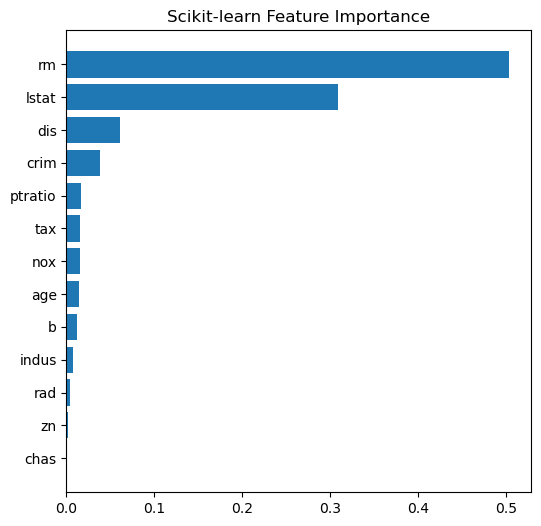

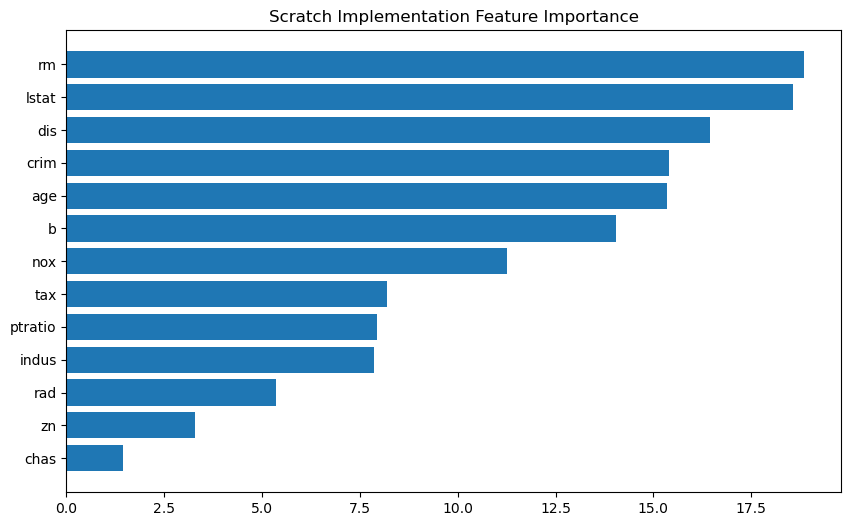

In [16]:

from sklearn.ensemble import RandomForestRegressor

# Train scikit-learn's Random Forest
rf_sklearn = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_sklearn.fit(X_train, y_train)


import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn feature importance
plt.figure(figsize=(6,6))
importances = rf_sklearn.feature_importances_  
features = X_train.columns
plt.barh(features[np.argsort(importances)], np.sort(importances))
plt.title("Scikit-learn Feature Importance")
plt.show()

# Scratch implementation feature importance
def get_scratch_importance(forest, feature_names):
    importance = np.zeros(len(feature_names))
    for tree in forest.trees:
        if hasattr(tree, 'tree') and isinstance(tree.tree, dict):
            stack = [tree.tree]
            while stack:
                node = stack.pop()
                if isinstance(node, dict):
                    importance[node['feature']] += 1
                    stack.append(node['left'])
                    stack.append(node['right'])
    return importance / len(forest.trees)

plt.figure(figsize=(10,6))
scratch_importance = get_scratch_importance(rf_scratch, features)
plt.barh(features[np.argsort(scratch_importance)], np.sort(scratch_importance))
plt.title("Scratch Implementation Feature Importance")
plt.show()

In [17]:
# Calculate predictions from both models
y_pred_scratch = rf_scratch.predict(X_test_np)  # From your scratch implementation
y_pred_rf = rf_sklearn.predict(X_test)         # From scikit-learn's implementation

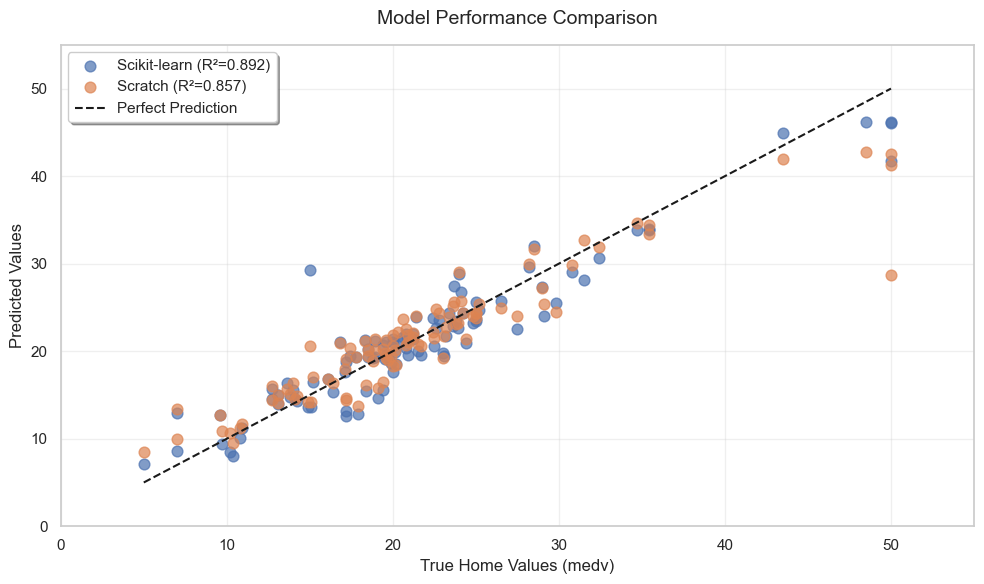

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')  


plt.figure(figsize=(10,6))

# Plot predictions with improved formatting
plt.scatter(y_test, y_pred_rf, alpha=0.7, s=60,
            label=f'Scikit-learn (R²={r2_score(y_test, y_pred_rf):.3f})')
plt.scatter(y_test, y_pred_scratch, alpha=0.7, s=60,
            label=f'Scratch (R²={r2_score(y_test, y_pred_scratch):.3f})')

# Reference line
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', lw=1.5, label='Perfect Prediction')

# Formatting
plt.xlabel('True Home Values (medv)', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, pad=15)
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)

# Set equal axis limits
ax_min = min(y_test.min(), y_pred_rf.min(), y_pred_scratch.min()) - 5
ax_max = max(y_test.max(), y_pred_rf.max(), y_pred_scratch.max()) + 5
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)

plt.tight_layout()
plt.show()

In [19]:
# Training the scratch model with the same optimal parameters
rf_scratch = RandomForestRegressorScratch(
    n_estimators=100,
    max_depth=None,  # Now handled properly
    min_samples_split=2,
    max_features='auto'
)
rf_scratch.fit(X_train.values, y_train.values)

# Evaluate
y_pred_scratch = rf_scratch.predict(X_test.values)
scratch_r2 = r2_score(y_test, y_pred_scratch)
scratch_mse = mean_squared_error(y_test, y_pred_scratch)

print("\nScratch Implementation Results:")
print(f"R2 Score: {scratch_r2:.4f}")
print(f"MSE: {scratch_mse:.4f}")


Scratch Implementation Results:
R2 Score: 0.8583
MSE: 10.3932


In [20]:
residuals_sklearn = y_test - y_pred_rf
residuals_scratch = y_test - y_pred_scratch



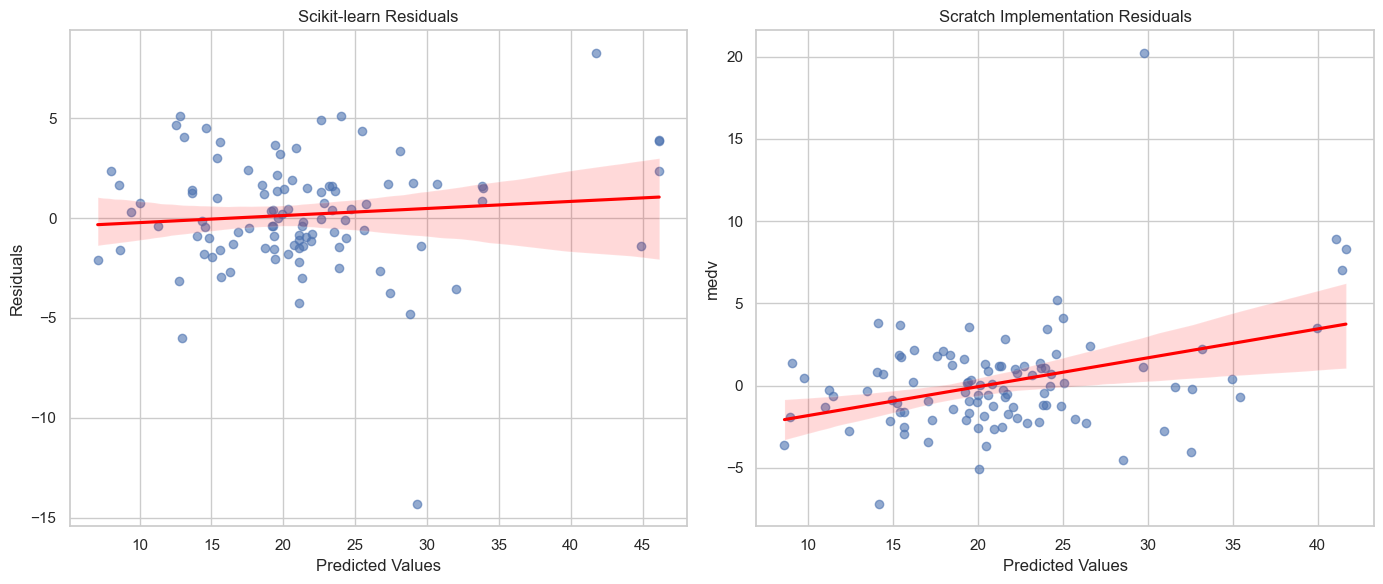

In [21]:
sns.set_theme(style='whitegrid')

plt.figure(figsize=(14,6))

# Left plot - Scikit-learn
plt.subplot(1,2,1)
sns.regplot(x=y_pred_rf, y=residuals_sklearn, 
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Scikit-learn Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Right plot - Scratch
plt.subplot(1,2,2)
sns.regplot(x=y_pred_scratch, y=residuals_scratch, 
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Scratch Implementation Residuals')
plt.xlabel('Predicted Values')

plt.tight_layout()
plt.show()

In [22]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_squared_error
import time

# For scikit-learn
start = time.time()
rf_sklearn.fit(X_train, y_train)
sklearn_time = time.time() - start

# For scratch implementation
start = time.time()
rf_scratch.fit(X_train_np, y_train_np)
scratch_time = time.time() - start

#  metrics for both models
sklearn_r2 = r2_score(y_test, y_pred_rf)
sklearn_mse = mean_squared_error(y_test, y_pred_rf)

scratch_r2 = r2_score(y_test, y_pred_scratch)
scratch_mse = mean_squared_error(y_test, y_pred_scratch)

#  comparison table
comparison = [
    ["Metric", "Scikit-learn", "Scratch"],
    ["R² Score", f"{sklearn_r2:.4f}", f"{scratch_r2:.4f}"],
    ["MSE", f"{sklearn_mse:.4f}", f"{scratch_mse:.4f}"],
    ["Training Time",f"{sklearn_time}", f"{scratch_time}"]  
]

print(tabulate(comparison, headers="firstrow", tablefmt="grid"))

+---------------+----------------+-----------+
| Metric        |   Scikit-learn |   Scratch |
+===============+================+===========+
| R² Score      |       0.8923   |    0.8583 |
+---------------+----------------+-----------+
| MSE           |       7.9015   |   10.3932 |
+---------------+----------------+-----------+
| Training Time |       0.451799 |   25.864  |
+---------------+----------------+-----------+
